<a href="https://colab.research.google.com/github/shpcode/Restricted-Boltzmann-Machine-RBM-/blob/main/Langevian_NB_RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
from torchvision.transforms import ToTensor
import itertools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [ ]:
# getting data
IMAGE_SIZE = 28
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

# composed = transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,)),
#                        lambda x: x>0,
#                        lambda x: x.float(),
#             ])

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

for valid,bla in validation_loader:
  x_valid = torch.flatten(valid,start_dim=2,end_dim=3)
  break


In [ ]:
class EBM:
  def __init__(self, x_dim, h_dim):
    self.x_dim = x_dim
    self.h_dim = h_dim
    self.theta = torch.nn.init.normal_(torch.empty(self.x_dim, self.h_dim),mean=0.0, std=0.1).to(device)
    self.c     = torch.nn.init.normal_(torch.empty(1         , self.h_dim),mean=0.0, std=0.1).to(device)

  def L(self,x):
    return (torch.matmul(x,self.theta)+self.c)

  def En(self,x):
    return torch.log( 1+ torch.exp( self.L(x) ) ).sum(1)

  def grad_para(self,x):

    del_c = torch.sigmoid(self.L(x))
    del_theta = x.unsqueeze(1).tile(1,h_dim,1) * del_c.unsqueeze(2).tile(1,1,x_dim)
    return del_theta , del_c


  def langevin(self, x, e, MC_steps):

    # his_x=[] ; his_del=[]
    ## sample new x_ starting from datapoint x
    x_ = x.clone()
    rand  = torch.normal(mean=torch.zeros(MC_steps, x_dim), std= e ).to(device)
    for i in range(MC_steps):
      #his_x.append(x_.numpy())
      del_x  = (self.theta.unsqueeze(0).tile(x_.shape[0],1,1) * torch.sigmoid(self.L(x_)).unsqueeze(1).tile(1,x_dim,1)).sum(2)
      x_ = x_ - 0.5*e**2* del_x + rand[i,:]

     #  his_del.append(del_x.numpy()) ; his_x , his_del
    return x_

  def train(self, x, MC_steps , e,  lr):  '''Need to add regularization to En output'''

    # sampling model
    x_ =self.langevin( x, e, MC_steps)

    ## positive (data)
    pos_theta , pos_c = self.grad_para(x)
    ## negative (model)
    neg_theta , neg_c = self.grad_para(x_)

    ## update
    self. theta = self.theta +lr* (pos_theta -neg_theta).mean(0).T
    self. c     = self.c     +lr* (pos_c     -neg_c    ).mean(0).T

In [ ]:
x_dim= 784 ; h_dim = 500
ebm = EBM(x_dim , h_dim )
ebm.theta.norm()

tensor(62.6793, device='cuda:0')

In [ ]:
# his_x, his_del  = ebm.langevin(x, e=1,MC_steps=1000)
# plt.plot( np.asanyarray(his_x)[:,1,8])
# plt.plot( np.asanyarray(his_del)[:,1,6])

In [ ]:
epochs = 10
for e in range(epochs):
  print(e)
  for x, bla in train_loader:
    x = torch.flatten(x,start_dim=2,end_dim=3).squeeze()
    x = (x - x.mean(0)) / (x.std(0)+0.01)

    ebm.train(x.to(device), MC_steps=60 , e=0.1,  lr=0.01)




0
1
2
3
4
5
6
7
8
9


In [ ]:
ebm.theta.norm()

tensor(28856.2324, device='cuda:0')

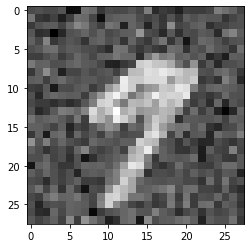

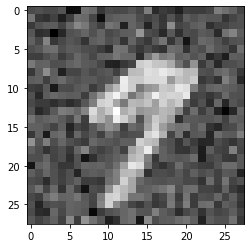

In [ ]:
x= torch.normal(torch.zeros(IMAGE_SIZE**2),std=0.2) +torch.flatten(validation_dataset[20][0])

# x= torch.normal(torch.zeros(IMAGE_SIZE*IMAGE_SIZE),std=0.01)
plt.imshow(x.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

x_ = ebm.langevin(x.to(device), e=0.1,MC_steps=100)

x_=x_.cpu().numpy()

# plt.imshow((validation_dataset[0][0]).squeeze().numpy(), cmap='gray')
plt.imshow(x.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [ ]:
x = torch.randint(low=0,high=2, size=(1,IMAGE_SIZE**2)).float()
# x=torch.flatten(validation_dataset[21][0]).unsqueeze(0)
chain = 10000
for step in range(chain):
  x = rbm.reconstruct(x,w,b,c)
x=x.detach().numpy()
plt.imshow(x.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

NameError: ignored